In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
import numpy as np
import pickle
import sys
import torch

sys.path.append("../")
from plotting_utils import custom_marginal_plot

from sbi.simulators import simulate_in_batches
from sbi.inference import prepare_for_sbi
from sbi.analysis import pairplot, conditional_pairplot
from sbi.inference import SNPE

from consbi import DATA_PATH, RESULTS_PATH

plt.style.use('../plotting_settings.mplstyle')
%matplotlib inline

# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load literature inference results
with open(RESULTS_PATH.joinpath("npe_dso_constrained_2p_gaussian_05_n500000r2x100k.p"), "rb") as fh:
    prior, estimator, posteriors, thos, xos, kwargs, seed = pickle.load(fh).values()
    
# Notes: posteriors contains the amortized posterior and the 2nd-round one conditioned on xo.

## Load predictive samples and data

In [3]:
xo = np.array([[0.4300, 0.4300, 0.4200, 0.6400, 0.1700, 0.4400, 0.0900]])
obs_labels = [r"L4", r"L4SEP", r"L4SP", r"L4SS", r"L5IT", r"L5PT", r"L6"]
param_labels = [r"$\theta_{pre}$", r"$\theta_{post}$", r"$\theta_{postAll}$"]

In [4]:
with open(DATA_PATH.joinpath("presimulated_dso_constrained_2p_gaussian_05_n500000.p"), "rb") as fh: 
    prior, ths, xs = pickle.load(fh).values()

ndims = ths.shape[1]

## Run SBC

In [5]:
from sbi.analysis import run_sbc, sbc_rank_plot
N = 1000
ranks, dap = run_sbc(ths[:N], xs[:N], posteriors[0], )

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

## Marginal plots for predictive posteriors

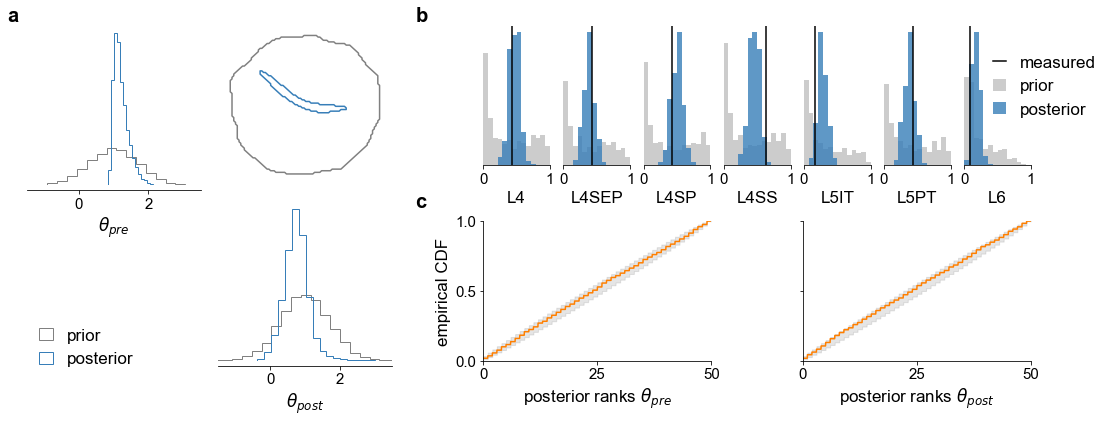

In [9]:
fig = plt.figure(figsize=(18, 6))
outer_grid = fig.add_gridspec(1, 2, wspace=.2, hspace=0, width_ratios=[.4, .6])
num_samples = 10000
# set KDE values
kde_bins = 100
hist_bins = 20
handlelength = 0.8
bw_method = 0.3
dim_data = 7
dim_params = 3

# left column
left_grid = outer_grid[0, 0].subgridspec(ndims, ndims, wspace=0.1, hspace=0.1)
ax1 = left_grid.subplots()  # Create all subplots for the inner

# right column
right_grid = outer_grid[0, 1].subgridspec(2, 1, wspace=0.1, hspace=0.4)
ax2 = right_grid[0, 0].subgridspec(1, 7, wspace=0.2, hspace=0.1).subplots()
ax3 = right_grid[1, 0].subgridspec(1, 2, wspace=0.4, hspace=0.1).subplots()


pairplot_opts = dict(upper="kde", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.99]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=kde_bins, bw_method=bw_method),
                      kde_diag=dict(bins=kde_bins, bw_method=bw_method),
                      labels = param_labels,
           )

## posterior predictives DSO
fig, ax1 = pairplot([ths[:num_samples], thos[:num_samples]], 
#                     points=xo.squeeze(), 
                    limits=[[-1.5, 3.5] * ndims],
                    labels=param_labels, 
                    points_offdiag=pairplot_opts["points_offdiag"],
                    points_colors=["k"],
                    upper="contour", 
                    kde_offdiag=dict(bins=kde_bins, bw_method=bw_method),
                    contour_offdiag=dict(levels=[0.99]),
                    diag="hist",
                    hist_diag=dict(bins=hist_bins, histtype="step", density=True),
                    samples_colors=["gray", colors[0]],
                    axes=ax1,
                    fig=fig,
                   )

plt.sca(ax1[0, 0])
plt.legend(["prior", "posterior", "measured"], 
           bbox_to_anchor=(.7, -.8), 
           handlelength=handlelength,
           loc=0)

## Posterior predictive
bins = np.linspace(0, 1, 15)
# prior predictive
custom_marginal_plot(ax2, xs.numpy(),
                     points=xo,
                     x_label="prior", 
                     points_label="measured", 
                     show_xlabels=False,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color="gray", 
                     histtype="stepfilled",
                     alpha=0.4,
                     plot_legend=False,
                    )
custom_marginal_plot(ax2, xos.numpy(),
                     x_label="posterior", 
                     points=None,
                     points_label="measured", 
                     show_xlabels=True,
                     labels=obs_labels,
#                      show_tick_labels=False,  # not implemented
                     num_bins=bins,
                     color=colors[0], 
                     plot_legend=False,)

plt.sca(ax2[-1])
plt.legend(["measured", "prior", "posterior"], 
           bbox_to_anchor=(.2, .9), 
           handlelength=handlelength,
           loc=2)
# plt.sca(ax3[1])
# plt.axis("off")
fig, ax3 = sbc_rank_plot(ranks, 
                         num_posterior_samples=1000, 
                         parameter_labels=param_labels, 
                         colors=[colors[1], colors[2]],
                         fig=fig, 
                         ax=ax3,
                         kwargs=dict(
                             params_in_subplots=True,
#                              ranks_labels=[""],
                             uniform_region_alpha=0.2, 
                             line_alpha=1.
              ), 
             )
plt.sca(ax3[0])
plt.legend([])


# Add Letters.
weight = "bold"
fontsize = 20
y = 0.91
x = 0.11
dx = .315
dy = -0.43
fig.text(x, y, "a", fontsize=fontsize, fontweight=weight)
fig.text(x + dx, y, "b", fontsize=fontsize, fontweight=weight)
fig.text(x + dx, y + dy, "c", fontsize=fontsize, fontweight=weight);

In [29]:
for ftype in ["png", "pdf", "eps"]:
    fig.savefig(f"supp_fig5-two_param_dso.{ftype}", dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
